# 積層自己符号化器の学習

## データの読み込み

MATLABに用意されている，数字認識用訓練データを読み込む．訓練データには5000サンプルあり，xTrain{i} が i 番目の画像，tTrain(:,i) が i 番目の入力に対する教師信号ベクトル（画像が3なら，3番目だけが1で他が0のベクトル．0は10番目）．

In [1]:
[xTrainImages,tTrain] = digitTrainCellArrayData;

一部の訓練データの画像を表示．

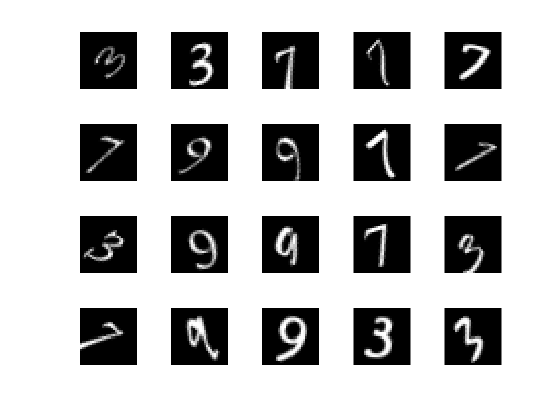

In [2]:
figure
for i = 1:20
    subplot(4,5,i);
    imshow(xTrainImages{i});
end

## 1段目の自己符号化器の学習
中間ノード数を 100 として1段目の自己符号化器を作成する．スパース正則化項の係数は 0.25, 目標とするスパース率（0でないノードの比率）を 0.05 として学習する．

In [3]:
rng('default'); % 結果が再現するよう，乱数のシードをデフォルト値に．
autoenc1 = trainAutoencoder(xTrainImages,100, ...
    'MaxEpochs', 400, ...
    'L2WeightRegularization', 0.004, ...
    'SparsityRegularization', 0.25, ...
    'SparsityProportion', 0.05, ...
    'ScaleData', false);

学習時に表示されたウィンドウを以下に示す．MacEpochs の 400 に到達して終了しているのが分かる．
![train autoenc1](img/train-autoenc1.png)

学習された重みを画像として表示する．

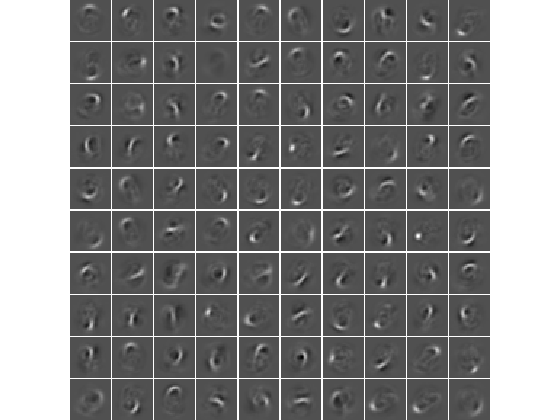

In [4]:
figure; plotWeights(autoenc1);

## 2段目の自己符号化器の学習

2段目の自己符号化器を学習するため，先ず，訓練データの画像を，1段目を使って符号化する． 

In [5]:
feat1 = encode(autoenc1,xTrainImages);

2段目は， feat1 に対する自己符号化器として学習される．ここでは，中間ノード数50で学習する．

In [7]:
autoenc2 = trainAutoencoder(feat1, 50, ...
    'MaxEpochs',100, ...
    'L2WeightRegularization',0.002, ...
    'SparsityRegularization',4, ...
    'SparsityProportion',0.1, ...
    'ScaleData', false);

学習時に表示されたウィンドウを示す．MaxEpoches の 100 に到達して終了してる．
![train autoenc2](img/train-autoenc2.png)

## softmax 層の学習

softmax 層を学習するため，先ずは feat1 を，2段目の符号化器を使って符号化する．

In [8]:
feat2 = encode(autoenc2, feat1);

関数 trainSoftmaxLayer で softmax 層を学習する．

In [9]:
softnet = trainSoftmaxLayer(feat2, tTrain, 'MaxEpochs', 400);

## 積層自己符号化器の作成
1，2段目の自己符号化器の符号化器と，softmax 層を重ねた3層の積層自己符号化器を作成する．関数 stack を使うだけで出来る．

In [10]:
deepnet = stack(autoenc1, autoenc2, softnet);

deepnet の構造を確認する．

In [11]:
view(deepnet)

![view deepnet](img/view-deepnet.png)
構成したばかりの積層自己符号化器の性能を確認する．まず，テスト集合を読み込む．

In [12]:
[xTestImages, tTest] = digitTestCellArrayData;

deepnet の入力に合わせるため，画像を列ベクトルに変換する．

In [13]:
xTest = zeros(numel(xTestImages{1}), numel(xTestImages));
for i = 1:numel(xTestImages)
    xTest(:,i) = xTestImages{i}(:);
end

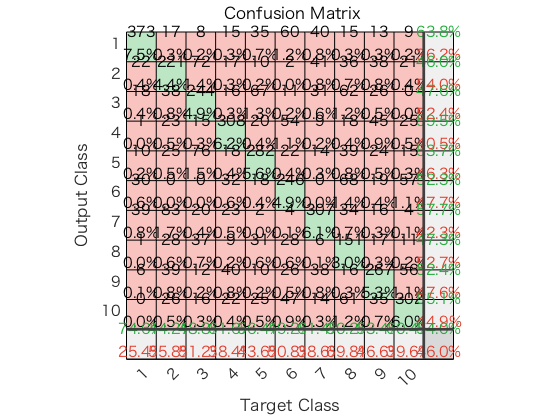

In [14]:
y = deepnet(xTest); % 各データの予測クラス分布を得る
plotconfusion(tTest,y); % 混同行列を表示

混同行列の表示が乱れているので，別に取り込んだ画像を以下に示す．
![confusion autoenc1](img/confusion1.png)

上の混同行列より，正解率は 57.5% と非常に低いことが分かる．このように，普通は，事前学習だけでは，あまり高い性能は得られない．

## ファインチューニング
構成された3層ネットワークを，訓練データに対して訓練する．この手続きは **ファインチューニング (fine tuning)** と呼ばれる．
先ず，訓練データを deepnet の入力と合うようにベクトルへ変換する．

In [15]:
xTrain = zeros(numel(xTrainImages{1}), numel(xTrainImages));
for i = 1:numel(xTrainImages)
    xTrain(:,i) = xTrainImages{i}(:);
end

変換した訓練データを使って，deepnet 全体を学習する．

In [16]:
deepnet = train(deepnet, xTrain, tTrain);

表示されたウィンドウは以下の通り．
![train deepnet](img/train-deepnet.png)

学習後の deepnet の性能を確認する．

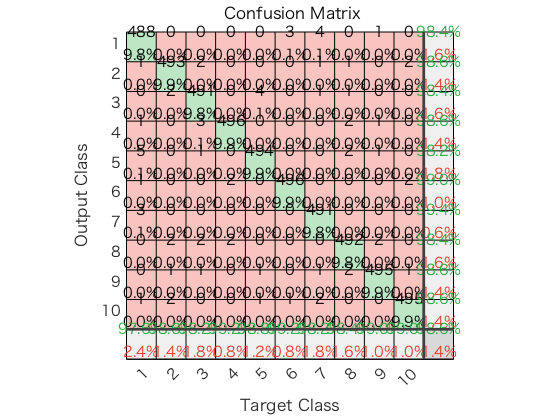

In [17]:
y = deepnet(xTest);
plotconfusion(tTest,y);

やはり画像が乱れるので，別に取り込んだ画像を示す．
![confusion2](img/confusion2.png)

ファインチューニングにより，精度は 98.6% に改善された．